In [25]:
import os
from dotenv import load_dotenv
from typing import TypedDict, Optional
from sqlalchemy import create_engine, text
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END

load_dotenv()
LANGSMITH_API_KEY=os.getenv("LANGSMITH_API_KEY")
LANGSMITH_PROJECT=os.getenv("LANGSMITH_PROJECT")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"

llm = ChatOpenAI(model="gpt-4o-mini")

In [26]:
# Set up DB
DB_PATH = r"sqlite:///sqllite/dummy_adidas_financials.db"

In [27]:
# LangChain Prompt Template
report_template = PromptTemplate(
    input_variables=[
        'year', 'cash_and_cash_equivalents', 'short_term_financial_assets',
        'accounts_receivable', 'inventories', 'property_plant_equipment',
        'goodwill', 'total_assets', 'short_term_borrowings', 'accounts_payable',
        'current_lease_liabilities', 'long_term_borrowings',
        'non_current_lease_liabilities', 'total_liabilities',
        'shareholders_equity', 'net_sales', 'cost_of_sales',
        'gross_profit', 'operating_profit', 'net_income'
    ],
    template="""
You are a financial analyst creating a summary for Adidas financials.

Given the data below:
Year: {year}
Cash & Equivalents: {cash_and_cash_equivalents}
Short-Term Financial Assets: {short_term_financial_assets}
Accounts Receivable: {accounts_receivable}
Inventories: {inventories}
Property, Plant & Equipment: {property_plant_equipment}
Goodwill: {goodwill}
Total Assets: {total_assets}
Short-Term Borrowings: {short_term_borrowings}
Accounts Payable: {accounts_payable}
Current Lease Liabilities: {current_lease_liabilities}
Long-Term Borrowings: {long_term_borrowings}
Non-Current Lease Liabilities: {non_current_lease_liabilities}
Total Liabilities: {total_liabilities}
Shareholders' Equity: {shareholders_equity}
Net Sales: {net_sales}
Cost of Sales: {cost_of_sales}
Gross Profit: {gross_profit}
Operating Profit: {operating_profit}
Net Income: {net_income}

Write a business-level summary analyzing profitability, liquidity, and financial health.
"""
)


In [28]:
# --- State Schema ---
class FinancialReportState(TypedDict):
    year: int
    financial_data: Optional[dict]
    report: Optional[str]

# --- Nodes ---

def fetch_data_node(state: FinancialReportState) -> FinancialReportState:
    year = state['year']
    engine = create_engine(DB_PATH)
    query = "SELECT * FROM financials WHERE year = :year LIMIT 1"
    with engine.connect() as conn:
        result = conn.execute(text(query), {"year": year}).mappings().first()
    if not result:
        raise ValueError(f"No financial data found for year {year}")
    state['financial_data'] = dict(result)
    return state

def generate_report_node(state: FinancialReportState) -> FinancialReportState:
    data = state['financial_data']
    if not data:
        raise ValueError("No financial data available to generate report.")
    prompt = report_template.format(**data)
    response = llm.invoke(prompt)
    state['report'] = response.content
    return state

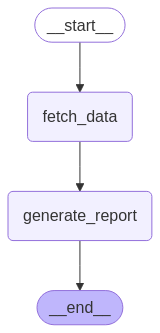

In [32]:
# --- Build Graph ---
from langgraph.graph import StateGraph
from IPython.display import Image, display

builder = StateGraph(FinancialReportState)

builder.add_node("fetch_data", fetch_data_node)
builder.add_node("generate_report", generate_report_node)

builder.set_entry_point("fetch_data")
builder.add_edge("fetch_data", "generate_report")
builder.add_edge("generate_report", END)

# --- Compile Graph ---
graph = builder.compile()

# --- Visualize Graph ---
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [30]:
# Example run
if __name__ == "__main__":
    try:
        year = int(input("Enter year (e.g., 2022): "))
        state = graph.invoke({"year": year})
        print("\n✅ Financial Report:\n")
        print(state['report'])
    except ValueError as e:
        print(f"❌ Error: {e}")



✅ Financial Report:

### Adidas Financial Summary for 2022

#### Overview
In 2022, Adidas faced a challenging financial landscape, characterized by a decrease in profitability but maintaining a solid asset base and manageable liabilities. This summary will analyze the company's profitability, liquidity, and overall financial health based on the provided financial data.

#### Profitability
- **Gross Profit**: Adidas reported a gross profit of **€10.32 billion**, indicating a healthy gross profit margin of approximately **43%** (calculated as Gross Profit/Net Sales). This margin signals effective management of production costs relative to sales.
- **Operating Profit**: The operating profit stood at **€1.26 billion**, leading to an operating margin of around **5.3%**. This reduction suggests increased operating expenses relative to revenue, which may stem from rising costs or lower sales efficiency.
- **Net Income**: The company reported a **net income of -€105.34 million**, a concerning